In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [2]:
train_data = pd.read_csv("train_data.csv", delimiter='\t', index_col=0)
test_data = pd.read_csv("test_data.csv", delimiter='\t', index_col=0)

In [3]:
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 32 columns):
ID           1319 non-null int64
Age          1319 non-null float64
Gender       1319 non-null float64
Education    1319 non-null float64
Country      1319 non-null float64
Ethnicity    1319 non-null float64
Nscore       1319 non-null float64
Escore       1319 non-null float64
Oscore       1319 non-null float64
Ascore       1319 non-null float64
Cscore       1319 non-null float64
Impulsive    1319 non-null float64
SS           1319 non-null float64
Alcohol      1319 non-null object
Amphet       1319 non-null object
Amyl         1319 non-null object
Benzos       1319 non-null object
Caff         1319 non-null object
Cannabis     1319 non-null object
Choc         1319 non-null object
Coke         1319 non-null object
Crack        1319 non-null object
Ecstacy      1319 non-null object
Heroin       1319 non-null object
Ketamine     1319 non-null object
Legalh       1319 non-null objec

In [5]:
# Drop ID, Chocolate, the fake drug Semer, and legal substances
train_data.drop(['ID', 'Choc', 'Semer', 'Alcohol', 'Nicotine', 'Caff','Legalh'], axis=1, inplace=True)
test_data.drop(['ID', 'Choc', 'Semer', 'Alcohol', 'Nicotine', 'Caff','Legalh'], axis=1, inplace=True)

In [6]:
for column in train_data.loc[:,'Amphet':]:
    # get label encoding for column
    train_data[column] = train_data[column].astype('category').cat.codes.astype('int32')
    test_data[column] = test_data[column].astype('category').cat.codes.astype('int32')

In [7]:
# Function to determine illegal drug usage per person
def is_drug_user(row):
    row = row['Amphet':]
    num_zeros = (row == 0).astype(bool).sum()
    if num_zeros == row.size:
        return False
    return True

In [8]:
# Combine illegal drug usage into a single boolean variable
train_data['Drug User'] = train_data.apply(is_drug_user, axis=1)
test_data['Drug User'] = test_data.apply(is_drug_user, axis=1)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 26 columns):
Age          1319 non-null float64
Gender       1319 non-null float64
Education    1319 non-null float64
Country      1319 non-null float64
Ethnicity    1319 non-null float64
Nscore       1319 non-null float64
Escore       1319 non-null float64
Oscore       1319 non-null float64
Ascore       1319 non-null float64
Cscore       1319 non-null float64
Impulsive    1319 non-null float64
SS           1319 non-null float64
Amphet       1319 non-null int32
Amyl         1319 non-null int32
Benzos       1319 non-null int32
Cannabis     1319 non-null int32
Coke         1319 non-null int32
Crack        1319 non-null int32
Ecstacy      1319 non-null int32
Heroin       1319 non-null int32
Ketamine     1319 non-null int32
LSD          1319 non-null int32
Meth         1319 non-null int32
Mushrooms    1319 non-null int32
VSA          1319 non-null int32
Drug User    1319 non-null bool
dtypes: bool

In [9]:
X_train = train_data.loc[:,'Age':'SS']
y_train = train_data['Drug User']

In [10]:
# Feature selection
sel = SelectFromModel(RandomForestClassifier(random_state=0), threshold=0.05)
sel.fit(X_train, y_train)
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat.values)

['Age' 'Education' 'Country' 'Nscore' 'Escore' 'Oscore' 'Ascore' 'Cscore'
 'Impulsive' 'SS']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [11]:
# Grid search for random forest
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 100, num = 20)] + [None]
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 20)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
grid = {'max_features': max_features,
        'max_depth': max_depth,
        'n_estimators': n_estimators,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap}

In [12]:
# Base classifier used for grid search
forest = RandomForestClassifier(random_state=0)
# Use 100 iterations and 10-fold cross-validation, using 4 cores
forest_grid_search = RandomizedSearchCV(estimator = forest, param_distributions = grid, 
                               n_iter = 100, cv = 10, verbose=2, random_state=0, n_jobs = 4)

In [13]:
# Use features selected for training and testing
X_train = train_data[selected_feat.values]
y_train = train_data['Drug User']

X_test = test_data[selected_feat.values]
y_test = test_data['Drug User']

In [14]:
# Fit features selected to grid search (slow process)
forest_grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   17.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  7.0min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=Non

In [15]:
params = forest_grid_search.best_params_

In [35]:
search_data = pd.DataFrame(forest_grid_search.cv_results_)
search_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 24 columns):
mean_fit_time              100 non-null float64
std_fit_time               100 non-null float64
mean_score_time            100 non-null float64
std_score_time             100 non-null float64
param_n_estimators         100 non-null object
param_min_samples_split    100 non-null object
param_min_samples_leaf     100 non-null object
param_max_features         100 non-null object
param_max_depth            93 non-null object
param_bootstrap            100 non-null object
params                     100 non-null object
split0_test_score          100 non-null float64
split1_test_score          100 non-null float64
split2_test_score          100 non-null float64
split3_test_score          100 non-null float64
split4_test_score          100 non-null float64
split5_test_score          100 non-null float64
split6_test_score          100 non-null float64
split7_test_score          100 non-null 

In [36]:
search_data['param_n_estimators'] = search_data['param_n_estimators'].astype('int32')

In [37]:
estimators = search_data[['param_n_estimators', 'mean_fit_time', 'mean_test_score']].sort_values(
    by=['param_n_estimators'])
estimators.head

<bound method NDFrame.head of     param_n_estimators  mean_fit_time  mean_test_score
37                 100       0.265417         0.840788
64                 100       0.283532         0.844579
94                 100       0.722160         0.843821
66                 147       0.368234         0.840788
26                 147       0.392712         0.846096
..                 ...            ...              ...
6                 1000       2.543067         0.842305
5                 1000       2.678169         0.846096
1                 1000       2.490128         0.842305
17                1000       2.808630         0.848370
41                1000       2.524662         0.847612

[100 rows x 3 columns]>

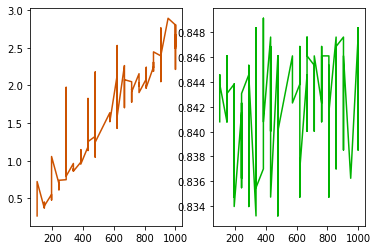

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False)
ax1.plot(estimators['param_n_estimators'], estimators['mean_fit_time'], color='#cc5200')
ax2.plot(estimators['param_n_estimators'], estimators['mean_test_score'], color='#00b300')
plt.show()

In [65]:
ax1.plot(estimators['param_n_estimators'], estimators['mean_fit_time'], color='#cc5200')
#plt.ylabel('Mean Training Time')
#plt.xlabel('Decision Trees')
#plt.title('Mean Training Time by Number of Decision Trees')
#plt.show()

In [66]:
ax2.plot(estimators['param_n_estimators'], estimators['mean_test_score'], color='#00b300')
#plt.ylabel('Mean Test Score')
#plt.xlabel('Decision Trees')
#plt.title('Mean Test Score by Number of Decision Trees')
#plt.show()

In [67]:
#pd.set_option('display.max_rows', 500)
max_depths = search_data[['param_max_depth', 'mean_test_score']]
max_depths = max_depths[max_depths['param_max_depth'].notnull()]
max_depths.reset_index(drop=True, inplace=True)
max_depths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 2 columns):
param_max_depth    93 non-null object
mean_test_score    93 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [68]:
max_depths.head

<bound method NDFrame.head of    param_max_depth  mean_test_score
0               40         0.846096
1               45         0.842305
2               35         0.841547
3               50         0.845337
4               80         0.836240
5               70         0.846096
6               90         0.842305
7               25         0.835481
8                5         0.844579
9               65         0.845337
10              85         0.846854
11              95         0.840030
12              95         0.844579
13              50         0.846096
14             100         0.842305
15              10         0.845337
16              40         0.848370
17              40         0.841547
18              35         0.843821
19               5         0.843821
20              45         0.843821
21              35         0.840788
22              10         0.846096
23              50         0.833207
24              90         0.846854
25             100         0.84609

In [69]:
max_depths = max_depths.sort_values(by=['param_max_depth'])

In [70]:
ax3.plot(max_depths['param_max_depth'], max_depths['mean_test_score'], color='#007acc')
#plt.ylabel('Mean Test Score')
#plt.xlabel('Max Depth of Decision Trees')
#plt.title('Mean Test Score by Decision Tree Depth')
plt.show()

In [ ]:
plt.plot(search_data['param_n_estimators'], search_data['mean_fit_time'])
plt.ylabel('Mean Test Score')
plt.show()

In [ ]:
estimators = search_data[['param_min_samples_split', 'mean_test_score']].sort_values(by=['param_min_samples_split'])
print(estimators.head)

plt.plot(estimators['param_min_samples_split'], estimators['mean_test_score'])
plt.ylabel('Estimators')
plt.show()

In [ ]:
search_data['param_n_estimators']

In [ ]:
# Get mean cross-validation score using best paramaters from grid search (hard-coded to skip grid search on rerun)
forest = RandomForestClassifier(n_estimators=194, min_samples_split=2, 
                                min_samples_leaf=2, max_features='auto', 
                                max_depth=35, bootstrap=True, random_state=0)

In [ ]:
scores = cross_val_score(forest, X_train, y_train, scoring='f1', cv=10)

In [ ]:
print("Mean F1 Score: %f"%(scores.mean()))

In [ ]:
forest = RandomForestClassifier(n_estimators=194, min_samples_split=2, 
                                min_samples_leaf=2, max_features='auto', 
                                max_depth=35, bootstrap=True, random_state=0)
forest.fit(X_train, y_train)

In [ ]:
# Calculate metrics
y_pred = forest.predict(X_test)
accuracy  = metrics.accuracy_score(y_test, y_pred)
error     = 1 - metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average=None)
recall    = metrics.recall_score(y_test, y_pred, average=None)
f1_score  = metrics.f1_score(y_test, y_pred, average=None)
print('Accuracy:  ', '%0.3f'%(accuracy))
print('Error:     ', '%0.3f'%(error))
print('Precision: ', precision)
print('Recall:    ', recall)
print('F1 score:  ', f1_score)